# Explarotary Data Analysis Notebook

## Time Domain Features 

- Frame (time):
    - Amplitude envelope 
        - Max amp value of all samples in a frame
        - Gives rough idea of loudness
        - Sensitive to outliers
        - Onset detection, music genre classification  
    - Root mean square energy
        - RMS of all samples in a frame
        - Indicator of loudness
        - Robust to outliers
        - Audio segmentation, music genre classification 
    - Zero-crossing rate (ZCRt)
        - Number of times a signal crosses the horizontal axis
        - Speech recognition 
        - Monophonic pitch estimation
        - Voice/unvoiced decision for speech signals  

## Frequency Domain Features 

- Spectrogram
    - Based on STFT, Framing, Hop, Windowing
    - Nice way to represent time-frequency 
- Mel Spectrogram
    - Same as spectrogram
    - perceptually-relevant frequency representation
    - `m = 2595*log(1+(f/500))`
    - Mel filter banks
    - Mel Spectrogram = (#bands,framesize/2+1).framesize/2+1,#frames) 
- MFCCs
    - Traditionally: first 12-13 coeff (formants)
    - add delta, delta_2 MFCCS to increase accuracy
    - Total 39 coeff per frame
    - * Not robust to noise
    - Used in speaker and speech recognition
- Band Energy Ratio
    - Provides energy of our signal, Ratio between small to high freq
    - Used in speech discrimination
- Spectral Centroid
    - Frequency band where most of the energy is concentarted
    - Weighted mean of the frequencies
    - Measure sound brightness
    - Audio classification
- Bandwidth
    - Spectral spread
    - Genre classification

## Import Packages

In [1]:
# Audio processing
import librosa
import librosa.display as ld
import IPython.display as ipd
# Data cleaning
import os
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
import sklearn
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Advanced options
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

## Read Data

In [96]:
# Cluster data for future work
opd_data = []
others_data = []
directory= "A:\Professional\Engineering CU\DSP_Data_New"
for dir in os.listdir(directory):
    if dir == "open the door":
        for filename in os.listdir(os.path.join(directory, dir)):
            path_opd = os.path.join(directory, dir, filename)
            opd_data.append(path_opd)
    else:
        for filename in os.listdir(os.path.join(directory, dir)):
            path_others = os.path.join(directory, dir, filename)
            others_data.append(path_others)

In [287]:
# Group all the data
data = []
data.extend(opd_data)
data.extend(others_data)

In [103]:
# Determine speakers
speaker = []
for d in data:
    if "adham" in d: # append 0 for adham
        speaker.append(0)
    if "mohmoud" in d: # append 1 for mahmoud
        speaker.append(1)
    if "ahmed" in d: # append 2 for ahmed
        speaker.append(2)
    if "maha" in d: # append 3 for maha
        speaker.append(3)
len(speaker)

80

In [109]:
# Fingerprint Dataframe
fp_df = pd.DataFrame()
fp_df['data'] = data
fp_df['speaker'] = speaker

## Implementation

In [123]:
fp_df[fp_df.speaker==3]['data']

18    A:\Professional\Engineering CU\DSP_Data_New\op...
19    A:\Professional\Engineering CU\DSP_Data_New\op...
20    A:\Professional\Engineering CU\DSP_Data_New\op...
21    A:\Professional\Engineering CU\DSP_Data_New\op...
22    A:\Professional\Engineering CU\DSP_Data_New\op...
23    A:\Professional\Engineering CU\DSP_Data_New\op...
24    A:\Professional\Engineering CU\DSP_Data_New\op...
25    A:\Professional\Engineering CU\DSP_Data_New\op...
26    A:\Professional\Engineering CU\DSP_Data_New\op...
58    A:\Professional\Engineering CU\DSP_Data_New\ot...
59    A:\Professional\Engineering CU\DSP_Data_New\ot...
60    A:\Professional\Engineering CU\DSP_Data_New\ot...
61    A:\Professional\Engineering CU\DSP_Data_New\ot...
62    A:\Professional\Engineering CU\DSP_Data_New\ot...
63    A:\Professional\Engineering CU\DSP_Data_New\ot...
64    A:\Professional\Engineering CU\DSP_Data_New\ot...
65    A:\Professional\Engineering CU\DSP_Data_New\ot...
66    A:\Professional\Engineering CU\DSP_Data_Ne

In [111]:
# Play data
ipd.Audio(fp_df[fp_df.speaker==0]['data'][5])

In [118]:
# Play data
ipd.Audio(fp_df[fp_df.speaker==1]['data'][30])

In [122]:
# Play data
ipd.Audio(fp_df[fp_df.speaker==2]['data'][50])

In [125]:
# Play data
ipd.Audio(fp_df[fp_df.speaker==3]['data'][64])

In [280]:
# Convert to array
temp_audio1, sr = librosa.load(fp_df.loc[5,['data']][0])
temp_audio2, _  = librosa.load(fp_df.loc[30,['data']][0])
temp_audio3, _ = librosa.load(fp_df.loc[50,['data']][0])
len(temp_audio3)

43277

### Time Features  

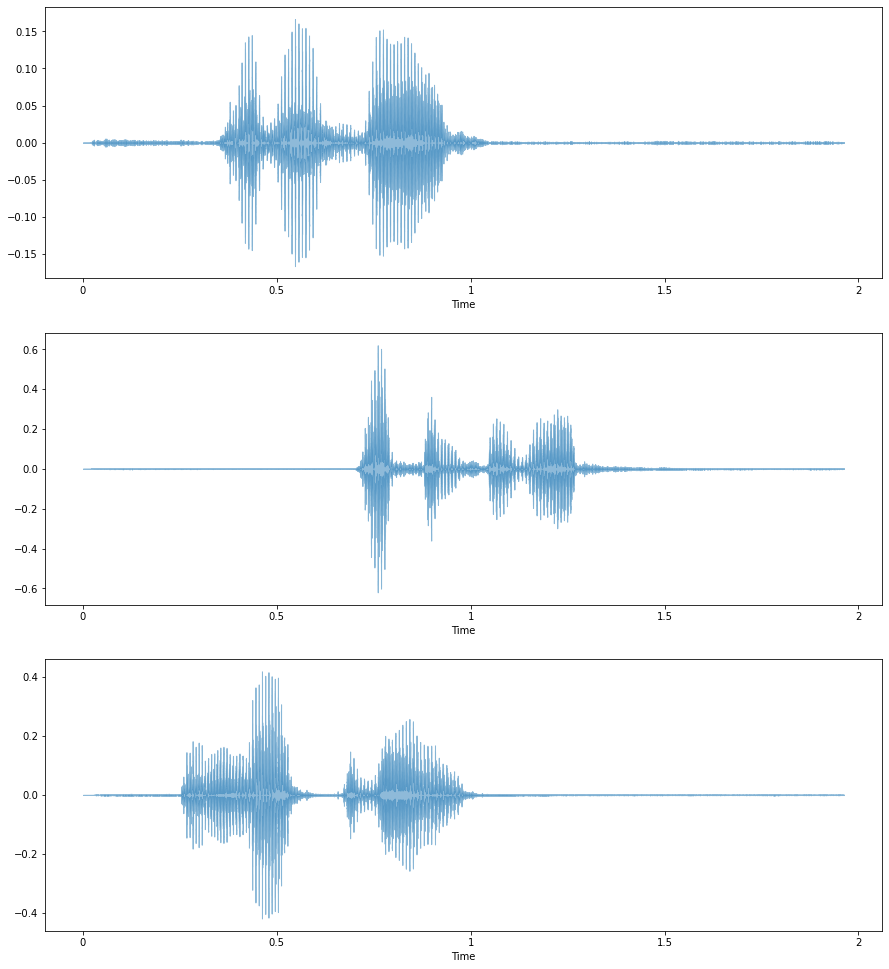

In [127]:
# visualize waveforms
plt.figure(figsize=(15,17))

plt.subplot(3,1,1)
ld.waveshow(temp_audio1, alpha=0.5)

plt.subplot(3,1,2)
ld.waveshow(temp_audio2, alpha=0.5)

plt.subplot(3,1,3)
ld.waveshow(temp_audio3, alpha=0.5)

In [128]:
FRAMESIZE = 1024
HOPLENGTH = 512
MELS = 13
SPLITFREQ = 2000

In [129]:
# Amplitude envelope implementation
def amplitude_envelope(signal, framesize, hoplength):
    amplitude_envelope = []
    
    # calculate AI for each frame
    for i in range(0, len(signal), hoplength):
        curr_frame = max(signal[i:i+framesize])
        amplitude_envelope.append(curr_frame)
    return amplitude_envelope

def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

In [130]:
ae_temp_audio1 = fancy_amplitude_envelope(temp_audio1, FRAMESIZE, HOPLENGTH)
ae_temp_audio2 = fancy_amplitude_envelope(temp_audio2, FRAMESIZE, HOPLENGTH)
ae_temp_audio3 = fancy_amplitude_envelope(temp_audio3, FRAMESIZE, HOPLENGTH)

In [131]:
ae_temp_audio2.shape

(85,)

In [132]:
t1 = librosa.frames_to_time(range(0, ae_temp_audio1.size), hop_length=HOPLENGTH)
t2 = librosa.frames_to_time(range(0, ae_temp_audio2.size), hop_length=HOPLENGTH)
t3 = librosa.frames_to_time(range(0, ae_temp_audio3.size), hop_length=HOPLENGTH)

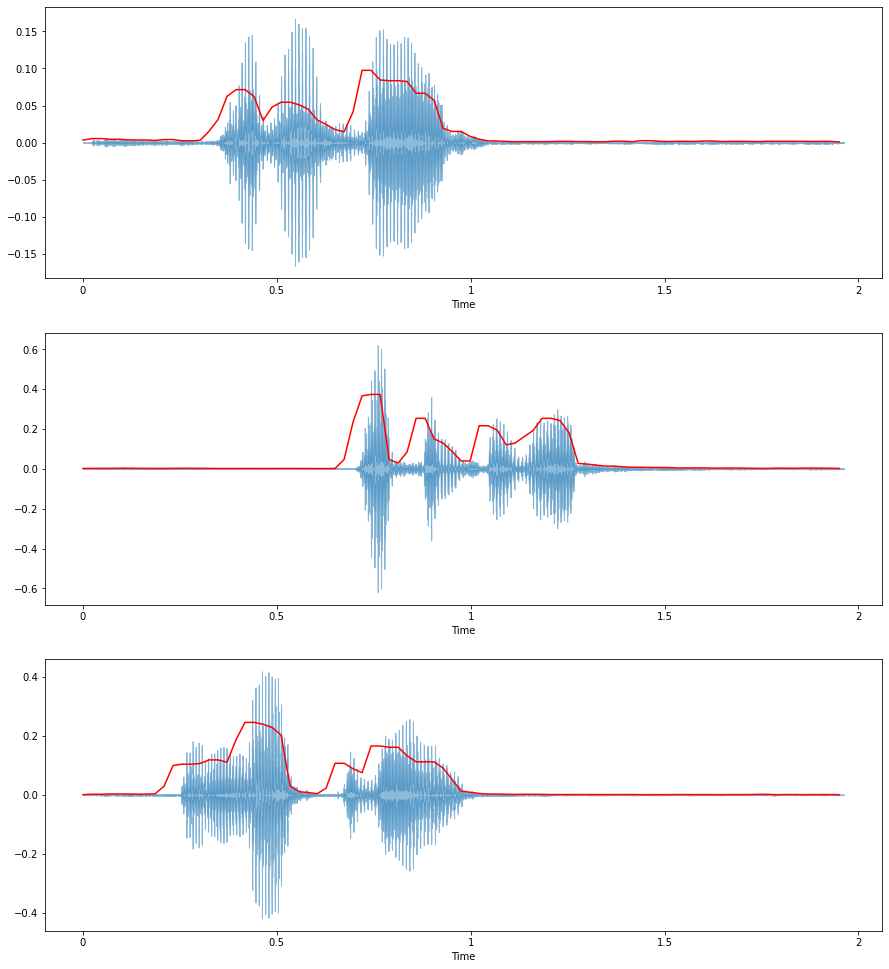

In [133]:
# visualize AE
plt.figure(figsize=(15,17))

plt.subplot(3,1,1)
ld.waveshow(temp_audio1, alpha=0.5)
plt.plot(t1, ae_temp_audio1, color='r')

plt.subplot(3,1,2)
ld.waveshow(temp_audio2, alpha=0.5)
plt.plot(t2, ae_temp_audio2, color='r')

plt.subplot(3,1,3)
ld.waveshow(temp_audio3, alpha=0.5)
plt.plot(t3, ae_temp_audio3, color='r')

In [134]:
# Extract RMSE
rms_temp_audio1 = librosa.feature.rms(temp_audio1, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
rms_temp_audio2 = librosa.feature.rms(temp_audio2, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
rms_temp_audio3 = librosa.feature.rms(temp_audio3, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]

In [135]:
rms_temp_audio1.shape

(85,)

In [136]:
t1 = librosa.frames_to_time(range(0, rms_temp_audio1.size), hop_length=HOPLENGTH)
t2 = librosa.frames_to_time(range(0, rms_temp_audio2.size), hop_length=HOPLENGTH)
t3 = librosa.frames_to_time(range(0, rms_temp_audio3.size), hop_length=HOPLENGTH)

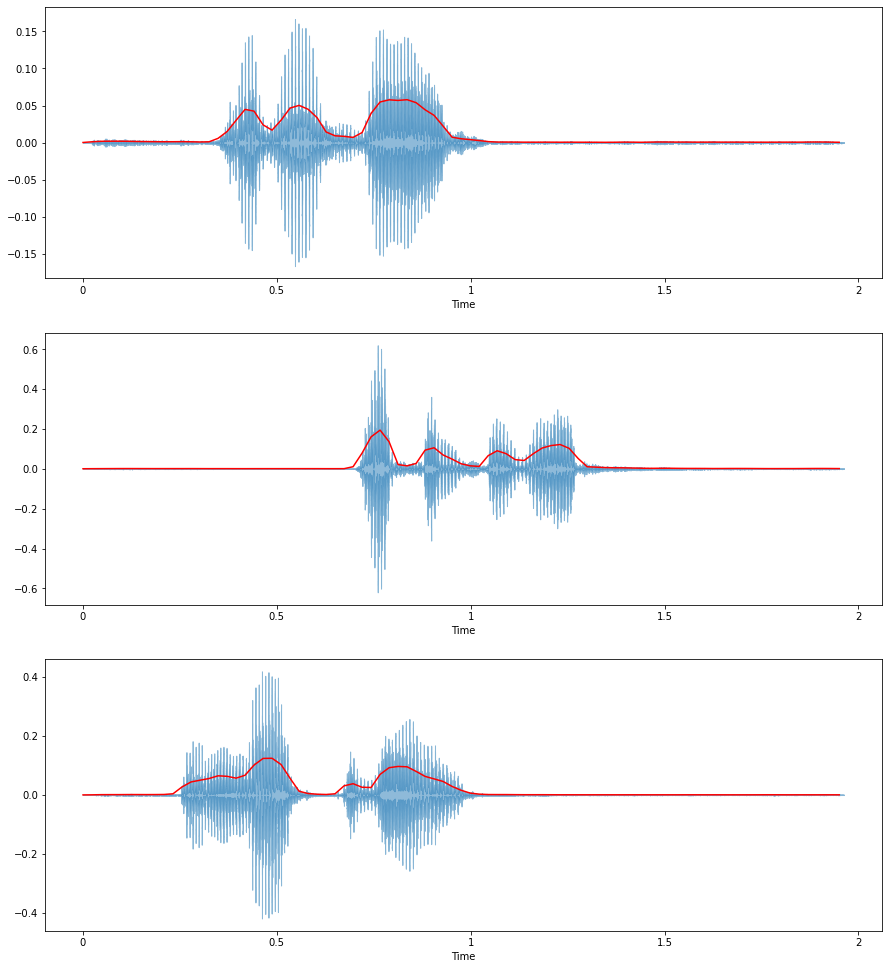

In [137]:
# plot RMSE
plt.figure(figsize=(15,17))

plt.subplot(3,1,1)
ld.waveshow(temp_audio1, alpha=0.5)
plt.plot(t1, rms_temp_audio1, color='r')

plt.subplot(3,1,2)
ld.waveshow(temp_audio2, alpha=0.5)
plt.plot(t2, rms_temp_audio2, color='r')

plt.subplot(3,1,3)
ld.waveshow(temp_audio3, alpha=0.5)
plt.plot(t3, rms_temp_audio3, color='r')


In [138]:
# Extract RMSE
zcr_temp_audio1 = librosa.feature.zero_crossing_rate(temp_audio1, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
zcr_temp_audio2 = librosa.feature.zero_crossing_rate(temp_audio2, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
zcr_temp_audio3 = librosa.feature.zero_crossing_rate(temp_audio3, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]

t1 = librosa.frames_to_time(range(0, zcr_temp_audio1.size), hop_length=HOPLENGTH)
t2 = librosa.frames_to_time(range(0, zcr_temp_audio2.size), hop_length=HOPLENGTH)
t3 = librosa.frames_to_time(range(0, zcr_temp_audio3.size), hop_length=HOPLENGTH)

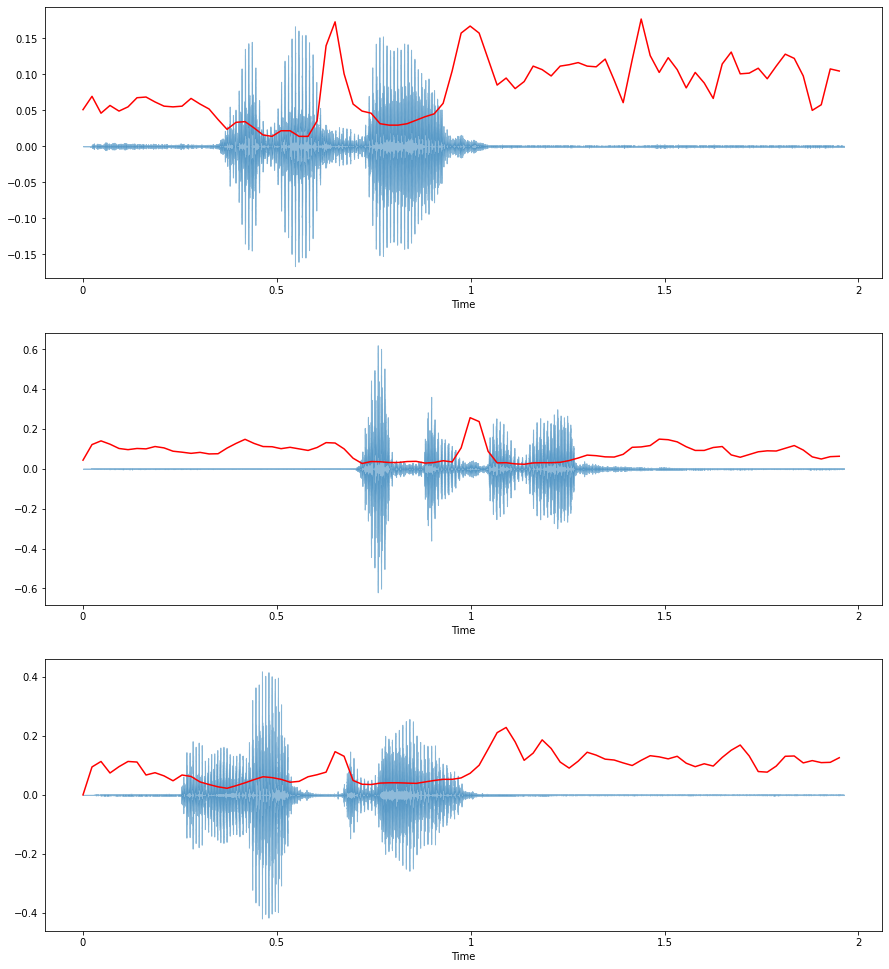

In [139]:
# plot ZCR
plt.figure(figsize=(15,17))

plt.subplot(3,1,1)
ld.waveshow(temp_audio1, alpha=0.5)
plt.plot(t1, zcr_temp_audio1, color='r')

plt.subplot(3,1,2)
ld.waveshow(temp_audio2, alpha=0.5)
plt.plot(t2, zcr_temp_audio2, color='r')

plt.subplot(3,1,3)
ld.waveshow(temp_audio3, alpha=0.5)
plt.plot(t3, zcr_temp_audio3, color='r')

I think according to the time-domain features:
- AE: could be a useful feature and it could be better done in the frequency domain, because it define formants there
    - Added
- RMSE: the most useful feature we could get in the time domain
    - Added
- ZCR: I think its completely garbage for our case
    - Not Added

### Frequency Features  

In [140]:
# Implement Mel Spectrogram
mel_temp_audio1 = librosa.feature.melspectrogram(temp_audio1, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS)
mel_temp_audio2 = librosa.feature.melspectrogram(temp_audio2, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS)
mel_temp_audio3 = librosa.feature.melspectrogram(temp_audio3, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS)
mel_temp_audio3.shape

(13, 85)

In [141]:
log_mel_temp_audio1 = librosa.power_to_db(mel_temp_audio1)
log_mel_temp_audio2 = librosa.power_to_db(mel_temp_audio2)
log_mel_temp_audio3 = librosa.power_to_db(mel_temp_audio3)
log_mel_temp_audio3.shape

(13, 85)

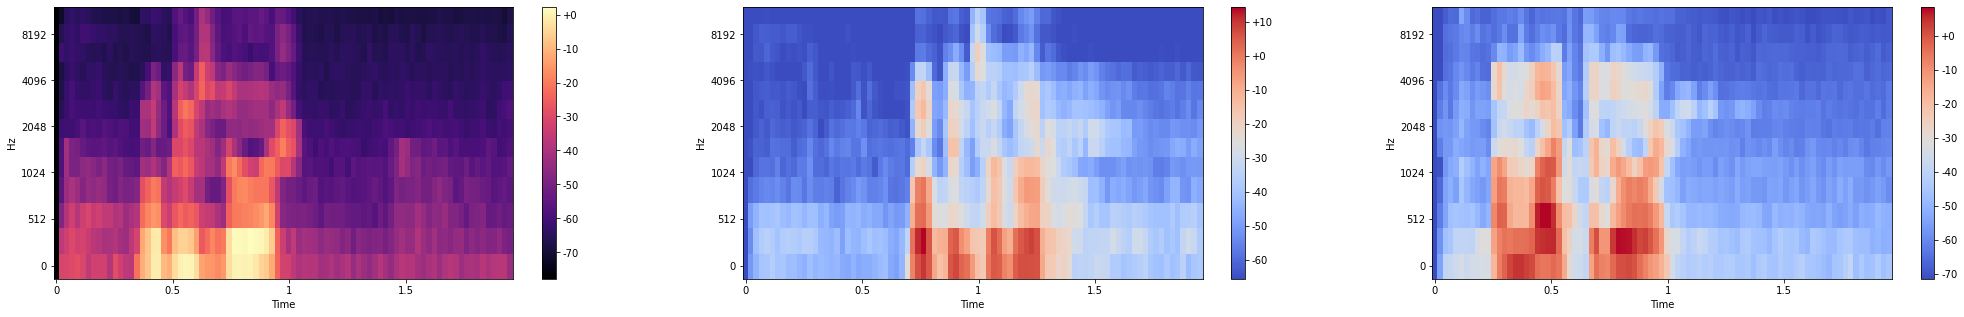

In [142]:
# plot Mel Spectrogram
plt.figure(figsize=(35,5))

plt.subplot(1,3,1)
ld.specshow(log_mel_temp_audio1, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,2)
ld.specshow(log_mel_temp_audio2, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,3)
ld.specshow(log_mel_temp_audio3, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

In [143]:
# Implement MFCCS
mfccs_temp_audio1 = librosa.feature.mfcc(y=temp_audio1, n_mfcc=13, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
mfccs_temp_audio2 = librosa.feature.mfcc(y=temp_audio2, n_mfcc=13, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
mfccs_temp_audio3 = librosa.feature.mfcc(y=temp_audio3, n_mfcc=13, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
mfccs_temp_audio1.shape

(13, 85)

In [144]:
delta_mfccs_temp_audio1 = librosa.feature.delta(mfccs_temp_audio1)
delta_mfccs_temp_audio2 = librosa.feature.delta(mfccs_temp_audio2)
delta_mfccs_temp_audio3 = librosa.feature.delta(mfccs_temp_audio3)
delta_mfccs_temp_audio1.shape

(13, 85)

In [145]:
delta2_mfccs_temp_audio1 = librosa.feature.delta(mfccs_temp_audio1, order=2)
delta2_mfccs_temp_audio2 = librosa.feature.delta(mfccs_temp_audio2, order=2)
delta2_mfccs_temp_audio3 = librosa.feature.delta(mfccs_temp_audio3, order=2)
delta2_mfccs_temp_audio1.shape

(13, 85)

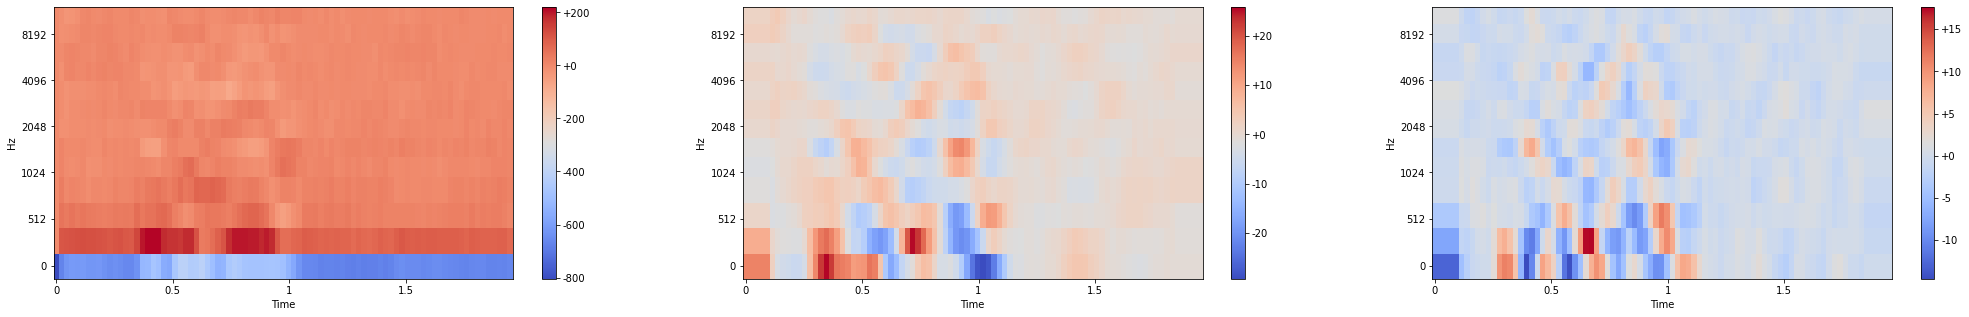

In [146]:
# plot Mel Spectrogram
plt.figure(figsize=(35,5))


# Adham Audio
plt.subplot(1,3,1)
ld.specshow(mfccs_temp_audio1, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,2)
ld.specshow(delta_mfccs_temp_audio1, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,3)
ld.specshow(delta2_mfccs_temp_audio1, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

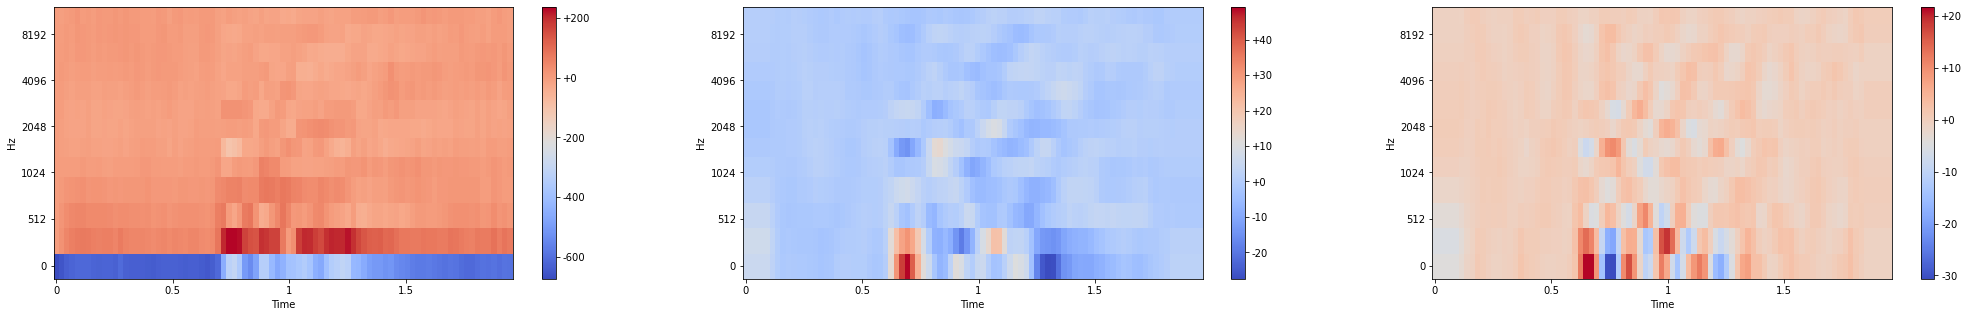

In [147]:
# plot Mel Spectrogram
plt.figure(figsize=(35,5))


# Ahmed Audio
plt.subplot(1,3,1)
ld.specshow(mfccs_temp_audio2, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,2)
ld.specshow(delta_mfccs_temp_audio2, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,3)
ld.specshow(delta2_mfccs_temp_audio2, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

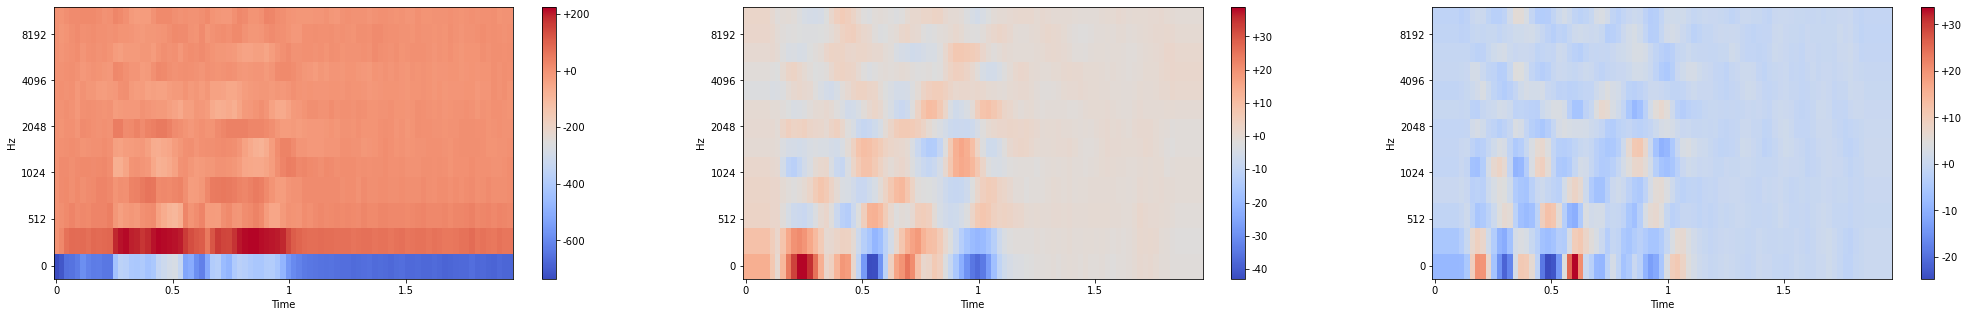

In [148]:
# plot MFCCs
plt.figure(figsize=(35,5))


# Maha Audio
plt.subplot(1,3,1)
ld.specshow(mfccs_temp_audio3, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,2)
ld.specshow(delta_mfccs_temp_audio3, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

plt.subplot(1,3,3)
ld.specshow(delta2_mfccs_temp_audio3, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")

In [149]:
mfccs_features_temp_audio1 = np.concatenate((mfccs_temp_audio1, delta_mfccs_temp_audio1, delta2_mfccs_temp_audio1))
mfccs_features_temp_audio2 = np.concatenate((mfccs_temp_audio2, delta_mfccs_temp_audio2, delta2_mfccs_temp_audio2))
mfccs_features_temp_audio3 = np.concatenate((mfccs_temp_audio3, delta_mfccs_temp_audio3, delta2_mfccs_temp_audio3))
mfccs_features_temp_audio1.shape

(39, 85)

In [150]:
# Implement Band Energy Ratio
spec_temp_audio1 = librosa.stft(temp_audio1, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
spec_temp_audio2 = librosa.stft(temp_audio2, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
spec_temp_audio3 = librosa.stft(temp_audio3, n_fft=FRAMESIZE, hop_length=HOPLENGTH)
spec_temp_audio1.shape

(513, 85)

In [151]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = int(split_frequency / frequency_delta_per_bin)
    return split_frequency_bin

In [152]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
        band_energy_ratio[band_energy_ratio == 'nan'] = 0
        
    return np.array(band_energy_ratio)

In [153]:
ber_temp_audio1 = band_energy_ratio(spec_temp_audio1, SPLITFREQ, sr)
ber_temp_audio2 = band_energy_ratio(spec_temp_audio2, SPLITFREQ, sr)
ber_temp_audio3 = band_energy_ratio(spec_temp_audio3, SPLITFREQ, sr)
len(ber_temp_audio1)

85

In [154]:
t1 = librosa.frames_to_time(range(0, ber_temp_audio1.size), hop_length=HOPLENGTH)
t2 = librosa.frames_to_time(range(0, ber_temp_audio2.size), hop_length=HOPLENGTH)
t3 = librosa.frames_to_time(range(0, ber_temp_audio3.size), hop_length=HOPLENGTH)

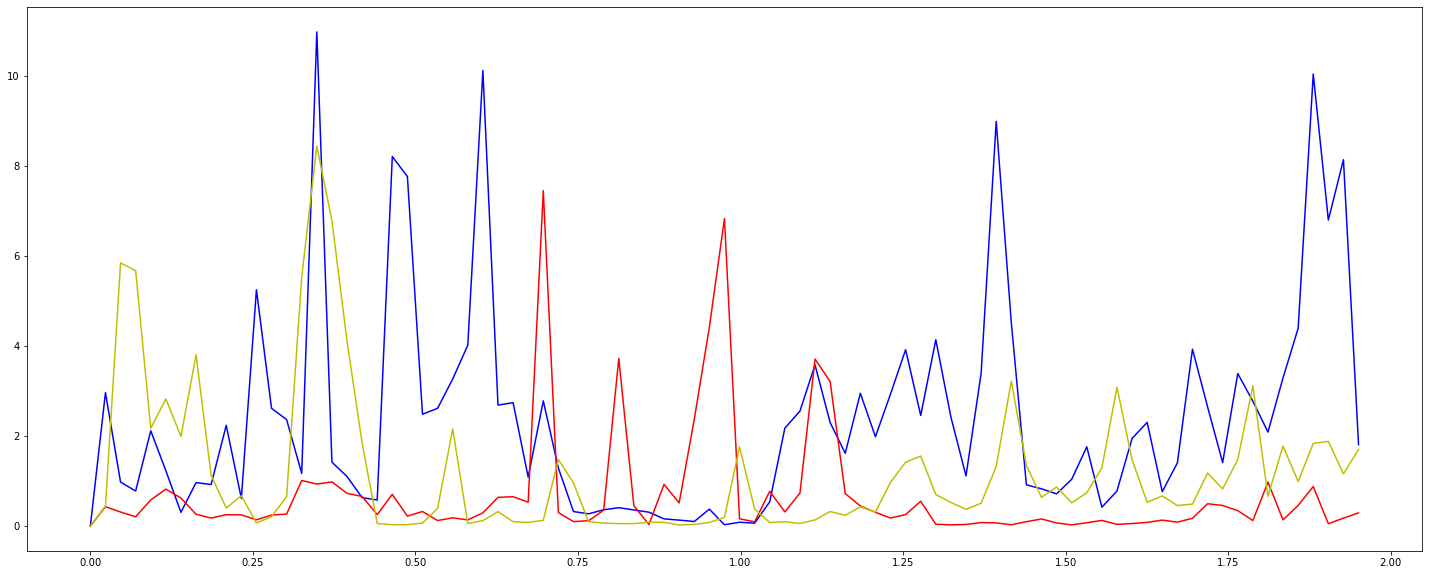

In [155]:
plt.figure(figsize=(25, 10))

plt.plot(t1, ber_temp_audio1, color="b")
plt.plot(t2, ber_temp_audio2, color="r")
plt.plot(t3, ber_temp_audio3, color="y")
plt.show()

In [156]:
print(np.mean(ber_temp_audio1))
print(np.mean(ber_temp_audio2))
print(np.mean(ber_temp_audio3))

2.4321910006377627
0.681084874666789
1.2074072362964645


In [157]:
# Implement Spectral Centroid 
sc_temp_audio1 = librosa.feature.spectral_centroid(y=temp_audio1, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
sc_temp_audio2 = librosa.feature.spectral_centroid(y=temp_audio2, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
sc_temp_audio3 = librosa.feature.spectral_centroid(y=temp_audio3, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
sc_temp_audio1.shape

(85,)

In [158]:
t1 = librosa.frames_to_time(range(0, sc_temp_audio1.size), hop_length=HOPLENGTH)
t2 = librosa.frames_to_time(range(0, sc_temp_audio2.size), hop_length=HOPLENGTH)
t3 = librosa.frames_to_time(range(0, sc_temp_audio3.size), hop_length=HOPLENGTH)

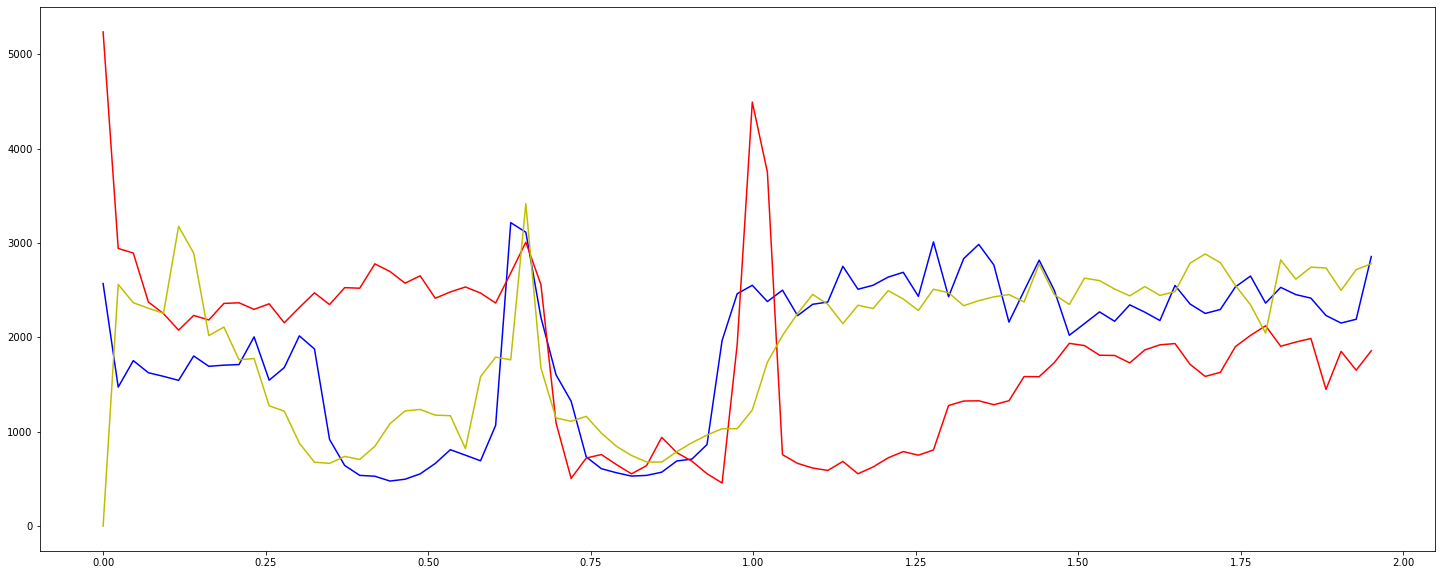

In [159]:
plt.figure(figsize=(25, 10))

plt.plot(t1, sc_temp_audio1, color="b")
plt.plot(t2, sc_temp_audio2, color="r")
plt.plot(t3, sc_temp_audio3, color="y")
plt.show()

In [160]:
print(np.mean(sc_temp_audio1))
print(np.mean(sc_temp_audio2))
print(np.mean(sc_temp_audio3))

1878.2952021789765
1802.6077992569963
1903.381340765238


I think according to the frequency-domain features:
- We can add all the features and futher apply dimensionality reduction on them

---